In [ ]:
# Copyright (c) Meta Platforms, Inc. and affiliates.

# Run Segment Anything Model 2 on a live video stream


In [ ]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import cv2
from IPython import display

In [ ]:
# use bfloat16 for the entire notebook
torch.autocast(device_type="cuda", dtype=torch.bfloat16).__enter__()

if torch.cuda.get_device_properties(0).major >= 8:
    # turn on tfloat32 for Ampere GPUs (https://pytorch.org/docs/stable/notes/cuda.html#tensorfloat-32-tf32-on-ampere-devices)
    torch.backends.cuda.matmul.allow_tf32 = True
    torch.backends.cudnn.allow_tf32 = True

### Loading the SAM 2 camera predictor


In [4]:
from sam2.build_sam import build_sam2_camera_predictor

sam2_checkpoint = "../checkpoints/sam2.1_hiera_small.pt"
model_cfg = "configs/sam2.1/sam2.1_hiera_s.yaml"

predictor = build_sam2_camera_predictor(model_cfg, sam2_checkpoint)

In [5]:
def show_mask(mask, ax, obj_id=None, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        cmap = plt.get_cmap("tab10")
        cmap_idx = 0 if obj_id is None else obj_id
        color = np.array([*cmap(cmap_idx)[:3], 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)


def show_points(coords, labels, ax, marker_size=200):
    pos_points = coords[labels == 1]
    neg_points = coords[labels == 0]
    ax.scatter(
        pos_points[:, 0],
        pos_points[:, 1],
        color="green",
        marker="*",
        s=marker_size,
        edgecolor="white",
        linewidth=1.25,
    )
    ax.scatter(
        neg_points[:, 0],
        neg_points[:, 1],
        color="red",
        marker="*",
        s=marker_size,
        edgecolor="white",
        linewidth=1.25,
    )


def show_bbox(bbox, ax, marker_size=200):
    tl, br = bbox[0], bbox[1]
    w, h = (br - tl)[0], (br - tl)[1]
    x, y = tl[0], tl[1]
    print(x, y, w, h)
    ax.add_patch(plt.Rectangle((x, y), w, h, fill=None, edgecolor="blue", linewidth=2))

#### Select an video stream (video or camera)


In [6]:
cap = cv2.VideoCapture("videos/aquarium/aquarium.mp4")
ret, frame = cap.read()
width, height = frame.shape[:2][::-1]

#### Step 1: Add a first click on the first frame


/home/kenta/sam2/sam2/sam2_camera_predictor.py:1152: UserWarning: cannot import name '_C' from 'sam2' (/home/kenta/sam2/sam2/__init__.py)

Skipping the post-processing step due to the error above. You can still use SAM 2 and it's OK to ignore the error above, although some post-processing functionality may be limited (which doesn't affect the results in most cases; see https://github.com/facebookresearch/sam2/blob/main/INSTALL.md).
  pred_masks_gpu = fill_holes_in_mask_scores(


600.0 214.0 165.0 72.0


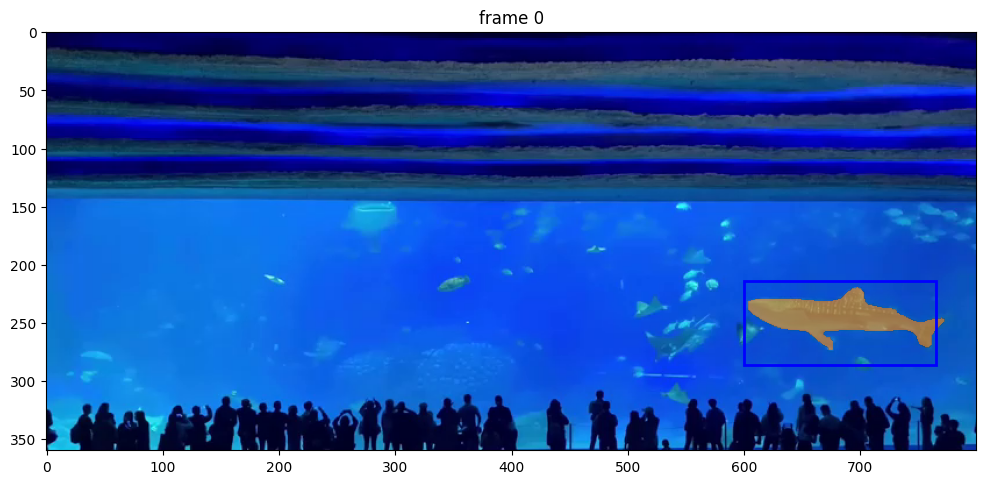

In [7]:
predictor.load_first_frame(frame)
if_init = True

using_point = False # if True, we use point prompt
using_box = True # if True, we use point prompt
using_mask= False  # if True, we use mask prompt

ann_frame_idx = 0  # the frame index we interact with
ann_obj_id = (
    1  # give a unique id to each object we interact with (it can be any integers)
)
# Let's add a positive click at (x, y) = (210, 350) to get started

# using point prompt
points = np.array([[670, 247]], dtype=np.float32)
# for labels, `1` means positive click and `0` means negative click
labels = np.array([1], dtype=np.int32)
bbox = np.array([[600, 214], [765, 286]], dtype=np.float32)

frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(12, 8))
plt.title(f"frame {ann_frame_idx}")
plt.imshow(frame)


if using_point:
    _, out_obj_ids, out_mask_logits = predictor.add_new_prompt(
        frame_idx=ann_frame_idx,
        obj_id=ann_obj_id,
        points=points,
        labels=labels,
    )
    show_points(points, labels, plt.gca())

elif using_box:
    _, out_obj_ids, out_mask_logits = predictor.add_new_prompt(
        frame_idx=ann_frame_idx, obj_id=ann_obj_id, bbox=bbox
    )
    show_bbox(bbox, plt.gca())

elif using_mask:
    mask_img_path="masks/aquarium/aquarium_mask.png"
    mask = cv2.imread(mask_img_path, cv2.IMREAD_GRAYSCALE)
    mask = mask / 255

    _, out_obj_ids, out_mask_logits = predictor.add_new_mask(
        frame_idx=ann_frame_idx, obj_id=ann_obj_id, mask=mask
    )
    


show_mask((out_mask_logits[0] > 0.0).cpu().numpy(), plt.gca(), obj_id=out_obj_ids[0])

#### Step 2: track


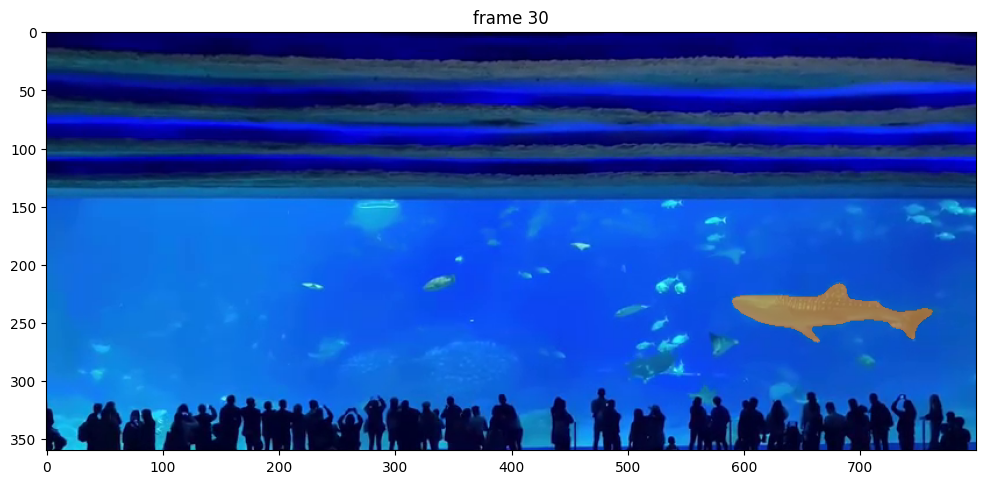

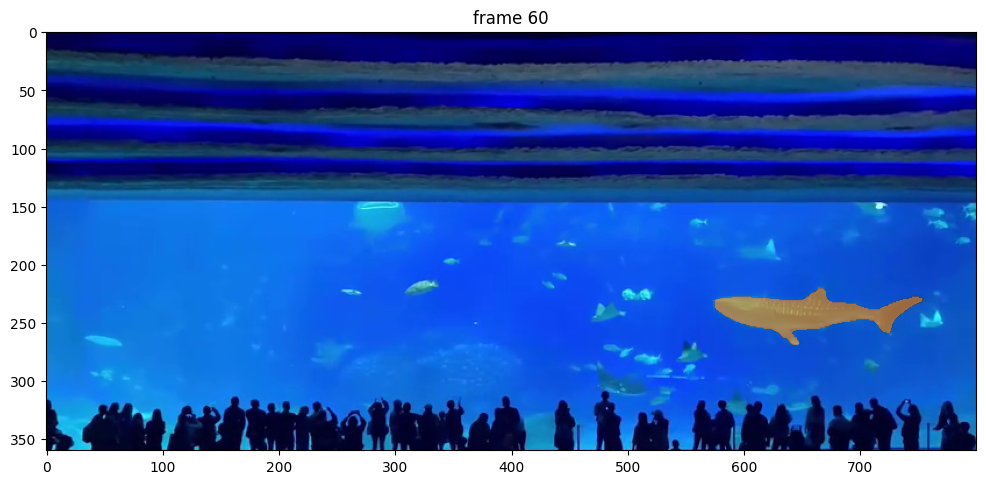

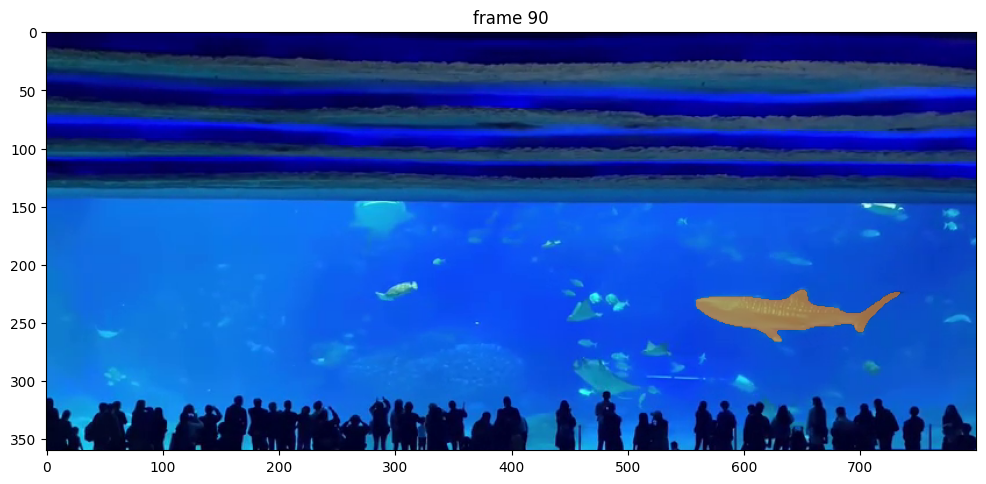

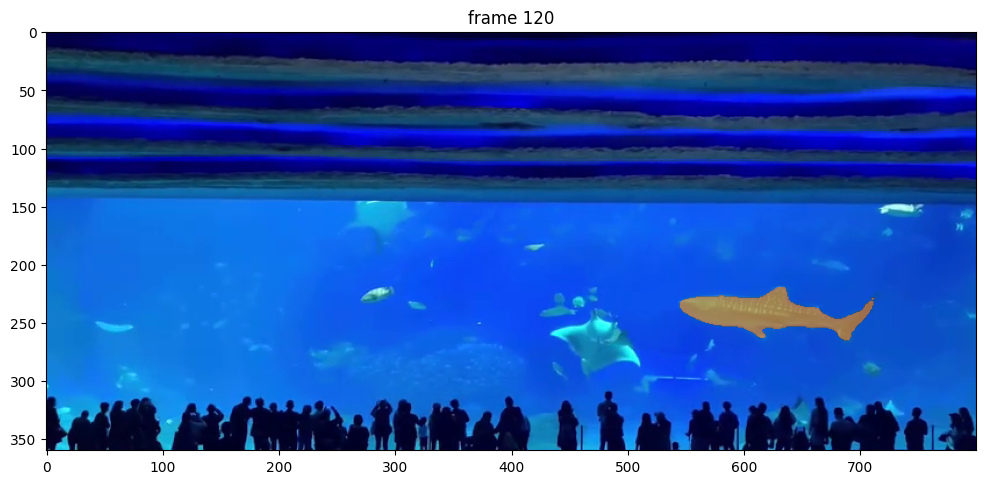

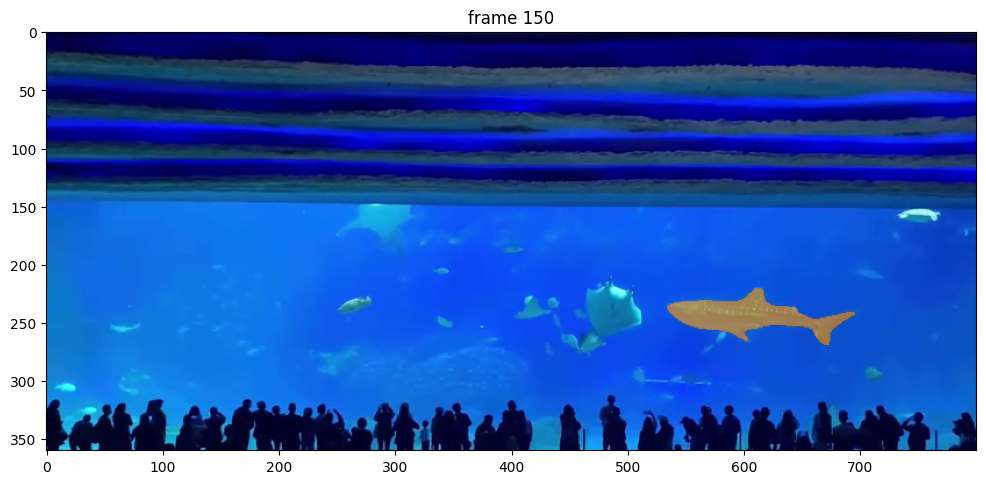

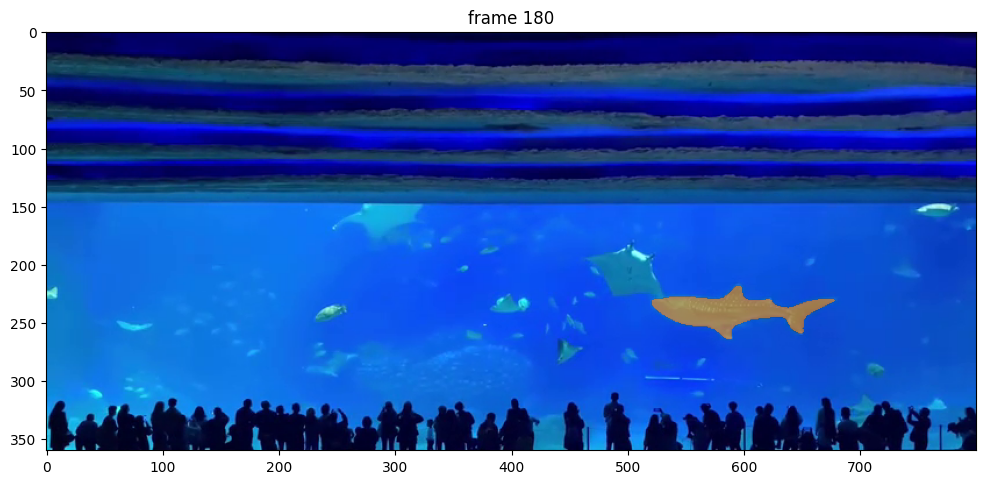

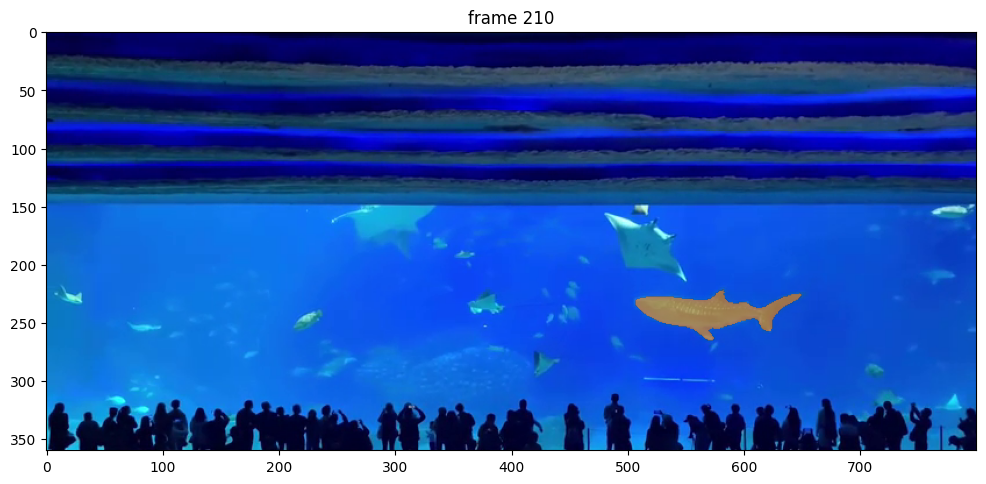

In [8]:
vis_gap = 30

while True:

    ret, frame = cap.read()
    ann_frame_idx += 1
    if not ret:
        break
    width, height = frame.shape[:2][::-1]

    out_obj_ids, out_mask_logits = predictor.track(frame)

    if ann_frame_idx % vis_gap == 0:
        print(f"frame {ann_frame_idx}")
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        display.clear_output(wait=True)
        plt.figure(figsize=(12, 8))
        plt.title(f"frame {ann_frame_idx}")
        plt.imshow(frame)
        show_mask(
            (out_mask_logits[0] > 0.0).cpu().numpy(), plt.gca(), obj_id=out_obj_ids[0]
        )

cap.release()